# 3D Multi-organ Segmentation with UNETR  (BTCV Challenge)
# PyTorch Lightning Tutorial


Prepared by: **Ali Hatamizadeh** and **Yucheng Tang**.

This tutorial demonstrates how to construct UNETR training workflow in PyTorch Lightning framework with MONAI for multi-organ segmentation task using the BTCV challenge dataset.

![image](https://lh3.googleusercontent.com/pw/AM-JKLU2eTW17rYtCmiZP3WWC-U1HCPOHwLe6pxOfJXwv2W-00aHfsNy7jeGV1dwUq0PXFOtkqasQ2Vyhcu6xkKsPzy3wx7O6yGOTJ7ZzA01S6LSh8szbjNLfpbuGgMe6ClpiS61KGvqu71xXFnNcyvJNFjN=w1448-h496-no?authuser=0)

And it contains the following features:
1. Transforms for dictionary format data.
1. Define a new transform according to MONAI transform API.
1. Load Nifti image with metadata, load a list of images and stack them.
1. Randomly adjust intensity for data augmentation.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNETR model, Dice loss function, Mean Dice metric for multi-oorgan segmentation task.

The dataset comes from https://www.synapse.org/#!Synapse:syn3193805/wiki/217752.  

Under Institutional Review Board (IRB) supervision, 50 abdomen CT scans of were randomly selected from a combination of an ongoing colorectal cancer chemotherapy trial, and a retrospective ventral hernia study. The 50 scans were captured during portal venous contrast phase with variable volume sizes (512 x 512 x 85 - 512 x 512 x 198) and field of views (approx. 280 x 280 x 280 mm3 - 500 x 500 x 650 mm3). The in-plane resolution varies from 0.54 x 0.54 mm2 to 0.98 x 0.98 mm2, while the slice thickness ranges from 2.5 mm to 5.0 mm. 

Target: 13 abdominal organs including 1. Spleen 2. Right Kidney 3. Left Kideny 4.Gallbladder 5.Esophagus 6. Liver 7. Stomach 8.Aorta 9. IVC 10. Portal and Splenic Veins 11. Pancreas 12 Right adrenal gland 13 Left adrenal gland.

Modality: CT
Size: 30 3D volumes (24 Training + 6 Testing)  
Challenge: BTCV MICCAI Challenge

The following figure shows image patches with the organ sub-regions that are annotated in the CT (top left) and the final labels for the whole dataset (right).

Data, figures and resources are taken from: 


1. [UNETR: Transformers for 3D Medical Image Segmentation](https://arxiv.org/abs/2103.10504)

2. [High-resolution 3D abdominal segmentation with random patch network fusion (MIA)](https://www.sciencedirect.com/science/article/abs/pii/S1361841520302589)

3. [Efficient multi-atlas abdominal segmentation on clinically acquired CT with SIMPLE context learning (MIA)](https://www.sciencedirect.com/science/article/abs/pii/S1361841515000766?via%3Dihub)


![image](https://lh3.googleusercontent.com/pw/AM-JKLX0svvlMdcrchGAgiWWNkg40lgXYjSHsAAuRc5Frakmz2pWzSzf87JQCRgYpqFR0qAjJWPzMQLc_mmvzNjfF9QWl_1OHZ8j4c9qrbR6zQaDJWaCLArRFh0uPvk97qAa11HtYbD6HpJ-wwTCUsaPcYvM=w1724-h522-no?authuser=0)



The image patches show anatomies of a subject, including: 
1. large organs: spleen, liver, stomach. 
2. Smaller organs: gallbladder, esophagus, kidneys, pancreas. 
3. Vascular tissues: aorta, IVC, P&S Veins. 
4. Glands: left and right adrenal gland

## Setup environment

In [1]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
!pip install -q pytorch-lightning==1.4.0
!pip install -q lightning-bolts==0.3.4
%matplotlib inline

/home/ali/anaconda3/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/ali/anaconda3/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/ali/anaconda3/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/ali/anaconda3/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/ali/anaconda3/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    list_data_collate,
)

import torch
import pytorch_lightning
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print_config()

MONAI version: 0.6.0
Numpy version: 1.21.0
Pytorch version: 1.6.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.1.1
scikit-image version: 0.14.2
Pillow version: 8.3.1
Tensorboard version: 2.2.0
gdown version: 3.13.0
TorchVision version: 0.7.0
ITK version: 5.1.2
tqdm version: 4.59.0
lmdb version: 1.2.1
psutil version: 5.6.1
pandas version: 0.24.2
einops version: 0.3.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpmqlv_tg7


## Download dataset and format in the folder.
    1. Download dataset from here: https://www.synapse.org/#!Synapse:syn3193805/wiki/89480\n
    2. Put images in the ./data/imagesTr
    3. Put labels in the ./data/labelsTr
    4. make JSON file accordingly: ./data/dataset_0.json
    Example of JSON file:
     {
    "description": "btcv yucheng",
    "labels": {
        "0": "background",
        "1": "spleen",
        "2": "rkid",
        "3": "lkid",
        "4": "gall",
        "5": "eso",
        "6": "liver",
        "7": "sto",
        "8": "aorta",
        "9": "IVC",
        "10": "veins",
        "11": "pancreas",
        "12": "rad",
        "13": "lad"
    },
    "licence": "yt",
    "modality": {
        "0": "CT"
    },
    "name": "btcv",
    "numTest": 20,
    "numTraining": 80,
    "reference": "Vanderbilt University",
    "release": "1.0 06/08/2015",
    "tensorImageSize": "3D",
    "test": [
        "imagesTs/img0061.nii.gz",
        "imagesTs/img0062.nii.gz",
        "imagesTs/img0063.nii.gz",
        "imagesTs/img0064.nii.gz",
        "imagesTs/img0065.nii.gz",
        "imagesTs/img0066.nii.gz",
        "imagesTs/img0067.nii.gz",
        "imagesTs/img0068.nii.gz",
        "imagesTs/img0069.nii.gz",
        "imagesTs/img0070.nii.gz",
        "imagesTs/img0071.nii.gz",
        "imagesTs/img0072.nii.gz",
        "imagesTs/img0073.nii.gz",
        "imagesTs/img0074.nii.gz",
        "imagesTs/img0075.nii.gz",
        "imagesTs/img0076.nii.gz",
        "imagesTs/img0077.nii.gz",
        "imagesTs/img0078.nii.gz",
        "imagesTs/img0079.nii.gz",
        "imagesTs/img0080.nii.gz"
    ],
    "training": [
        {
            "image": "imagesTr/img0001.nii.gz",
            "label": "labelsTr/label0001.nii.gz"
        },
        {
            "image": "imagesTr/img0002.nii.gz",
            "label": "labelsTr/label0002.nii.gz"
        },
        {
            "image": "imagesTr/img0003.nii.gz",
            "label": "labelsTr/label0003.nii.gz"
        },
        {
            "image": "imagesTr/img0004.nii.gz",
            "label": "labelsTr/label0004.nii.gz"
        },
        {
            "image": "imagesTr/img0005.nii.gz",
            "label": "labelsTr/label0005.nii.gz"
        },
        {
            "image": "imagesTr/img0006.nii.gz",
            "label": "labelsTr/label0006.nii.gz"
        },
        {
            "image": "imagesTr/img0007.nii.gz",
            "label": "labelsTr/label0007.nii.gz"
        },
        {
            "image": "imagesTr/img0008.nii.gz",
            "label": "labelsTr/label0008.nii.gz"
        },
        {
            "image": "imagesTr/img0009.nii.gz",
            "label": "labelsTr/label0009.nii.gz"
        },
        {
            "image": "imagesTr/img0010.nii.gz",
            "label": "labelsTr/label0010.nii.gz"
        },
        {
            "image": "imagesTr/img0021.nii.gz",
            "label": "labelsTr/label0021.nii.gz"
        },
        {
            "image": "imagesTr/img0022.nii.gz",
            "label": "labelsTr/label0022.nii.gz"
        },
        {
            "image": "imagesTr/img0023.nii.gz",
            "label": "labelsTr/label0023.nii.gz"
        },
        {
            "image": "imagesTr/img0024.nii.gz",
            "label": "labelsTr/label0024.nii.gz"
        },
        {
            "image": "imagesTr/img0025.nii.gz",
            "label": "labelsTr/label0025.nii.gz"
        },
        {
            "image": "imagesTr/img0026.nii.gz",
            "label": "labelsTr/label0026.nii.gz"
        },
        {
            "image": "imagesTr/img0027.nii.gz",
            "label": "labelsTr/label0027.nii.gz"
        },
        {
            "image": "imagesTr/img0028.nii.gz",
            "label": "labelsTr/label0028.nii.gz"
        },
        {
            "image": "imagesTr/img0029.nii.gz",
            "label": "labelsTr/label0029.nii.gz"
        },
        {
            "image": "imagesTr/img0030.nii.gz",
            "label": "labelsTr/label0030.nii.gz"
        },
        {
            "image": "imagesTr/img0031.nii.gz",
            "label": "labelsTr/label0031.nii.gz"
        },
        {
            "image": "imagesTr/img0032.nii.gz",
            "label": "labelsTr/label0032.nii.gz"
        },
        {
            "image": "imagesTr/img0033.nii.gz",
            "label": "labelsTr/label0033.nii.gz"
        },
        {
            "image": "imagesTr/img0034.nii.gz",
            "label": "labelsTr/label0034.nii.gz"
        }
    ],
    "validation": [
        {
            "image": "imagesTr/img0035.nii.gz",
            "label": "labelsTr/label0035.nii.gz"
        },
        {
            "image": "imagesTr/img0036.nii.gz",
            "label": "labelsTr/label0036.nii.gz"
        },
        {
            "image": "imagesTr/img0037.nii.gz",
            "label": "labelsTr/label0037.nii.gz"
        },
        {
            "image": "imagesTr/img0038.nii.gz",
            "label": "labelsTr/label0038.nii.gz"
        },
        {
            "image": "imagesTr/img0039.nii.gz",
            "label": "labelsTr/label0039.nii.gz"
        },
        {
            "image": "imagesTr/img0040.nii.gz",
            "label": "labelsTr/label0040.nii.gz"
        }
    ]
}
 

## Define the LightningModule (transform, network)
The LightningModule contains a refactoring of your training code. The following module is a refactoring of the code in spleen_segmentation_3d.ipynb:

In [4]:
class Net(pytorch_lightning.LightningModule):
    def __init__(self):
        super().__init__()
        
        self._model = UNETR(
            in_channels=1,
            out_channels=14,
            img_size=(96, 96, 96),
            feature_size=16,
            hidden_size=768,
            mlp_dim=3072,
            num_heads=12,
            pos_embed="perceptron",
            norm_name="instance",
            res_block=True,
            conv_block=True,
            dropout_rate=0.0,
        ).to(device)

        self.loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
        self.post_pred = AsDiscrete(argmax=True, to_onehot=True, n_classes=14)
        self.post_label = AsDiscrete(to_onehot=True, n_classes=14)
        self.dice_metric = DiceMetric(
            include_background=False, reduction="mean", get_not_nans=False
        )
        self.best_val_dice = 0
        self.best_val_epoch = 0
        self.max_epochs = 1300
        self.check_val = 30
        self.warmup_epochs = 20
        self.metric_values = []
        self.epoch_loss_values = []
        
        
    def forward(self, x):
        return self._model(x)

    def prepare_data(self):
        # prepare data
        # data_dir ='/dataset/dataset0/'
        data_dir = "/home/ali/Desktop/data_local/Synapse_Orig/"
        split_JSON = "dataset_0.json"
        datasets = data_dir + split_JSON
        datalist = load_decathlon_datalist(datasets, True, "training")
        val_files = load_decathlon_datalist(datasets, True, "validation")

        train_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                AddChanneld(keys=["image", "label"]),
                Spacingd(
                    keys=["image", "label"],
                    pixdim=(1.5, 1.5, 2.0),
                    mode=("bilinear", "nearest"),
                ),
                Orientationd(keys=["image", "label"], axcodes="RAS"),
                ScaleIntensityRanged(
                    keys=["image"],
                    a_min=-175,
                    a_max=250,
                    b_min=0.0,
                    b_max=1.0,
                    clip=True,
                ),
                CropForegroundd(keys=["image", "label"], source_key="image"),
                RandCropByPosNegLabeld(
                    keys=["image", "label"],
                    label_key="label",
                    spatial_size=(96, 96, 96),
                    pos=1,
                    neg=1,
                    num_samples=4,
                    image_key="image",
                    image_threshold=0,
                ),
                RandFlipd(
                    keys=["image", "label"],
                    spatial_axis=[0],
                    prob=0.10,
                ),
                RandFlipd(
                    keys=["image", "label"],
                    spatial_axis=[1],
                    prob=0.10,
                ),
                RandFlipd(
                    keys=["image", "label"],
                    spatial_axis=[2],
                    prob=0.10,
                ),
                RandRotate90d(
                    keys=["image", "label"],
                    prob=0.10,
                    max_k=3,
                ),
                RandShiftIntensityd(
                    keys=["image"],
                    offsets=0.10,
                    prob=0.50,
                ),
                ToTensord(keys=["image", "label"]),
            ]
        )
        val_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                AddChanneld(keys=["image", "label"]),
                Spacingd(
                    keys=["image", "label"],
                    pixdim=(1.5, 1.5, 2.0),
                    mode=("bilinear", "nearest"),
                ),
                Orientationd(keys=["image", "label"], axcodes="RAS"),
                ScaleIntensityRanged(
                    keys=["image"],
                    a_min=-175,
                    a_max=250,
                    b_min=0.0,
                    b_max=1.0,
                    clip=True,
                ),
                CropForegroundd(keys=["image", "label"], source_key="image"),
                ToTensord(keys=["image", "label"]),
            ]
        )

        self.train_ds = CacheDataset(
            data=datalist,
            transform=train_transforms,
            cache_num=24,
            cache_rate=1.0,
            num_workers=8,
        )
        self.val_ds = CacheDataset(
            data=val_files,
            transform=val_transforms,
            cache_num=6,
            cache_rate=1.0,
            num_workers=8,
        )

    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(
            self.train_ds,
            batch_size=1,
            shuffle=True,
            num_workers=8,
            pin_memory=True,
            collate_fn=list_data_collate,
        )
        return train_loader

    def val_dataloader(self):
        val_loader = torch.utils.data.DataLoader(
            self.val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
        )
        return val_loader
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self._model.parameters(), lr=1e-4, weight_decay=1e-5)
        return optimizer

    def training_step(self, batch, batch_idx):
        images, labels = (batch["image"].cuda(), batch["label"].cuda())
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        tensorboard_logs = {"train_loss": loss.item()}
        return {"loss": loss, "log": tensorboard_logs}
    
    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        self.epoch_loss_values.append(avg_loss.detach().cpu().numpy())

    
    def validation_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        roi_size = (96, 96, 96)
        sw_batch_size = 4
        outputs = sliding_window_inference(
            images, roi_size, sw_batch_size, self.forward)
        loss = self.loss_function(outputs, labels)
        outputs = [self.post_pred(i) for i in decollate_batch(outputs)]
        labels = [self.post_label(i) for i in decollate_batch(labels)]
        self.dice_metric(y_pred=outputs, y=labels)
        return {"val_loss": loss, "val_number": len(outputs)}


    def validation_epoch_end(self, outputs):
        val_loss, num_items = 0, 0
        for output in outputs:
            val_loss += output["val_loss"].sum().item()
            num_items += output["val_number"]
        mean_val_dice = self.dice_metric.aggregate().item()
        self.dice_metric.reset()
        mean_val_loss = torch.tensor(val_loss / num_items)
        tensorboard_logs = {
            "val_dice": mean_val_dice,
            "val_loss": mean_val_loss,
        }
        if mean_val_dice > self.best_val_dice:
            self.best_val_dice = mean_val_dice
            self.best_val_epoch = self.current_epoch
        print(
            f"current epoch: {self.current_epoch} "
            f"current mean dice: {mean_val_dice:.4f}"
            f"\nbest mean dice: {self.best_val_dice:.4f} "
            f"at epoch: {self.best_val_epoch}"
        )
        self.metric_values.append(mean_val_dice)
        return {"log": tensorboard_logs}


## Run the training

In [ ]:
# initialise the LightningModule
net = Net()

# set up checkpoints
checkpoint_callback = ModelCheckpoint(
    dirpath = root_dir,
    filename = "best_metric_model" 
)

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus = [0],
    max_epochs = net.max_epochs,
    check_val_every_n_epoch = net.check_val,
    callbacks = checkpoint_callback,
    default_root_dir=root_dir
)

# train
trainer.fit(net)

### Plot the loss and metric

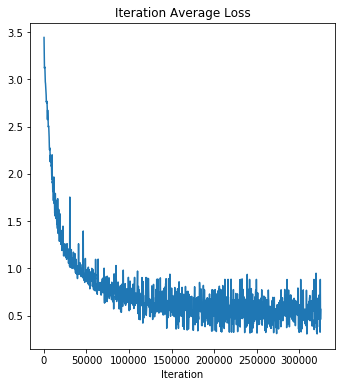

In [10]:
eval_num = 250
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(net.epoch_loss_values))]
y = net.epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

### Check best model output with the input image and label

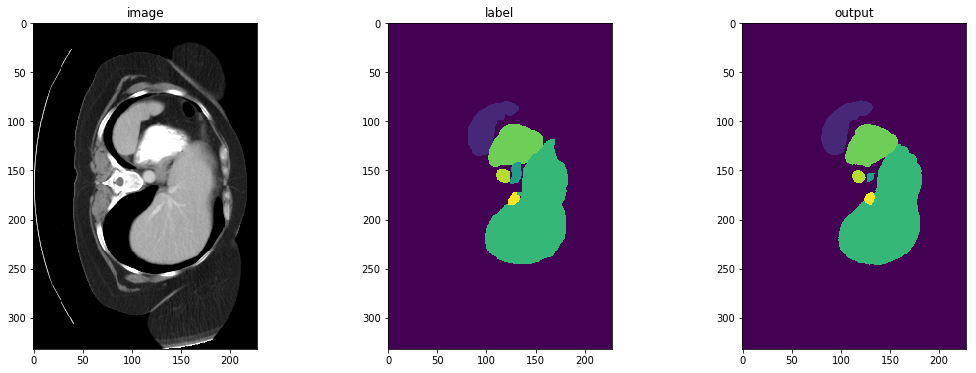

In [7]:
slice_map = {'img0035.nii.gz':170,'img0036.nii.gz':230,'img0037.nii.gz':204,'img0038.nii.gz':204,
             'img0039.nii.gz':204,'img0040.nii.gz':180}
case_num = 4
net.load_from_checkpoint(os.path.join(root_dir, "best_metric_model-v1.ckpt"))
net.eval()
net.to(device)

with torch.no_grad():
    img_name = os.path.split(net.val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    img = net.val_ds[case_num]["image"]
    label = net.val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (96, 96, 96), 4, net, overlap=0.8
    )
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title(f"image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title(f"label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title(f"output")
    plt.imshow(
        torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]]
    )
    plt.show()

### Cleanup data directory

Remove directory if a temporary was used.

In [8]:
if directory is None:
    shutil.rmtree(root_dir)